# Predictor de Popularidade de Músicas

**Índice**<a id='toc0_'></a>    
1. [Introdução](#toc1_)    
2. [Pré-processamento dos dados](#toc2_)    
2.1. [Importação dos módulos](#toc2_1_)    
2.2. [Upload dos dados](#toc2_2_)    
2.3. [Criação do dataframe](#toc2_3_)    
2.4. [Visualização do dataframe em bruto e de algumas métricas](#toc2_4_)    
3. [Análise Exploratória](#toc3_)    
3.1. [Distribuição dos valores em cada coluna](#toc3_1_)    
3.2. [Identificação de Valores Ausentes](#toc3_2_)    
3.3. [Identificação e remoção de duplicados](#toc3_3_)    
3.4. [Definir o índice](#toc3_4_)    
3.5. [Método do intervalo interquartil (IQR) para filtrar outliers](#toc3_5_)    
3.6. [Estatísticas do dataset](#toc3_6_)    
4. [Implementação de algoritmos de Aprendizagem Computacional](#toc4_)    
4.1. [Random Forest](#toc4_1_)    
5. [Resultados](#toc5_)    
6. [Considerações finais](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introdução](#toc0_)

## 2. <a id='toc2_'></a>[Pré-processamento dos dados](#toc0_)

In [38]:
# ! R -e "install.packages('IRkernel', repos = 'http://cran.us.r-project.org');IRkernel::installspec()"


R version 4.3.2 (2023-10-31) -- "Eye Holes"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-apple-darwin20 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



> install.packages('IRkernel', repos = 'http://cran.us.r-project.org');IRkernel::installspec()
trying URL 'http://cran.us.r-project.org/bin/macosx/big-sur-x86_64/contrib/4.3/IRkernel_1.3.2.tgz'
Content type 'application/x-gzip' length 228423 bytes (223 KB)
downloaded 223 KB


The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//Rtmpzz6YXY/downloaded_packages
> 
> 


In [39]:
# ! pip install rpy2

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
R.version.string

[1] "R version 4.3.2 (2023-10-31)"


### 2.1. <a id='toc2_1_'></a>[Importação dos módulos](#toc0_)

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

### 2.2. <a id='toc2_2_'></a>[Upload dos dados](#toc0_)

In [4]:
data = pd.read_csv('data/song_data.csv')

### 2.3. <a id='toc2_3_'></a>[Criação do dataframe](#toc0_)

In [5]:
df = pd.DataFrame(data)

### 2.4. <a id='toc2_4_'></a>[Visualização do dataframe em bruto e de algumas métricas](#toc0_)

In [6]:
df

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


## 3. <a id='toc3_'></a>[Análise Exploratória](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Distribuição dos valores em cada coluna](#toc0_)

In [8]:
col_names = df.columns

col_names

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [9]:
col_counts = {}

for col in col_names:
    col_counts[col] = df[col].value_counts()

col_counts


{'song_name': song_name
 Better                                            21
 FEFE (feat. Nicki Minaj & Murda Beatz)            19
 MIA (feat. Drake)                                 18
 Taki Taki (with Selena Gomez, Ozuna & Cardi B)    18
 No Stylist                                        17
                                                   ..
 Bassride                                           1
 The Beat                                           1
 We Are the Brave - Fatum Remix                     1
 Long Live House Music                              1
 Up to Me                                           1
 Name: count, Length: 13070, dtype: int64,
 'song_popularity': song_popularity
 58     404
 52     389
 55     388
 60     383
 63     378
       ... 
 98      47
 97      36
 93      32
 99      16
 100     12
 Name: count, Length: 101, dtype: int64,
 'song_duration_ms': song_duration_ms
 165000    25
 180000    21
 212500    20
 189000    20
 179404    19
           ..
 219682 

### 3.2. <a id='toc3_2_'></a>[Identificação de Valores Ausentes](#toc0_)

In [10]:
df.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

### 3.3. <a id='toc3_3_'></a>[Identificação e remoção de duplicados](#toc0_)

In [11]:
df = df[~df.duplicated()==1]

### 3.4. <a id='toc3_4_'></a>[Definir o índice](#toc0_)

In [12]:
df.set_index('song_name', inplace=True)

### 3.5. <a id='toc3_5_'></a>[Método do intervalo interquartil (IQR) para filtrar outliers](#toc0_)

In [13]:
numeric_columns = df.select_dtypes(include='number')

# Calcula Q1, Q3 e IQR para cada coluna numérica
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Define os limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

# Identifica e remove outliers
outliers = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)
df_no_outliers = df[~outliers]

In [14]:
df_no_outliers

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
song_name,,,,,,,,,,,,,,
Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.4740
In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.3700
By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.1980
How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.5740
Bring Me To Life,80,235893,0.008950,0.316,0.945,0.000002,4,0.3960,-3.169,0,0.1240,189.931,4,0.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stay Awake,55,114582,0.898000,0.370,0.136,0.000263,7,0.0999,-13.528,1,0.0433,146.081,4,0.0592
I Know,62,195106,0.395000,0.644,0.523,0.000000,4,0.0930,-7.660,1,0.0378,95.966,4,0.4450
Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.2650


Inferência:

Antes da remoção de duplicados e outliers, o conjunto de dados tinha 18835 amostras.

Após a remoção de duplicados e outliers, o conjunto de dados ficou com 8609 amostras.

In [15]:
%%R -i df_no_outliers
head(df_no_outliers)

/Users/pedrovenancio/opt/anaconda3/envs/bioinformatics/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


  song_popularity song_duration_ms acousticness danceability energy
1              73           262333     0.005520        0.496  0.682
2              66           216933     0.010300        0.542  0.853
3              74           216933     0.026400        0.451  0.970
4              56           223826     0.000954        0.447  0.766
5              80           235893     0.008950        0.316  0.945
6              81           199893     0.000504        0.581  0.887
  instrumentalness key liveness loudness audio_mode speechiness   tempo
1         2.94e-05   8   0.0589   -4.095          1      0.0294 167.060
2         0.00e+00   3   0.1080   -6.407          0      0.0498 105.256
3         3.55e-03   0   0.1020   -4.938          1      0.1070 122.444
4         0.00e+00  10   0.1130   -5.065          1      0.0313 172.011
5         1.85e-06   4   0.3960   -3.169          0      0.1240 189.931
6         1.11e-03   4   0.2680   -3.659          0      0.0624  90.578
  time_signature aud

### 3.6. <a id='toc3_6_'></a>[Estatísticas do dataset](#toc0_)

In [16]:
df_no_outliers.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.0,8609.000000
mean,50.310024,213975.428157,0.242148,0.635325,0.665632,0.000664,5.313625,0.153037,-6.836169,0.644674,0.068956,120.551641,4.0,0.556177
std,20.642530,41332.036956,0.266816,0.143342,0.195002,0.001883,3.572978,0.090994,2.849679,0.478640,0.046480,27.197993,0.0,0.241124
min,0.000000,93043.000000,0.000003,0.204000,0.039200,0.000000,0.000000,0.011900,-15.984000,0.000000,0.022400,52.181000,4.0,0.034100
25%,39.000000,186400.000000,0.025200,0.543000,0.535000,0.000000,2.000000,0.089900,-8.416000,0.000000,0.036100,99.937000,4.0,0.363000
50%,53.000000,211160.000000,0.130000,0.643000,0.692000,0.000003,6.000000,0.118000,-6.260000,1.000000,0.050500,119.954000,4.0,0.557000
75%,65.000000,238626.000000,0.395000,0.739000,0.822000,0.000159,8.000000,0.196000,-4.760000,1.000000,0.084300,137.132000,4.0,0.755000
max,100.000000,335693.000000,0.988000,0.981000,0.996000,0.012700,11.000000,0.420000,0.878000,1.000000,0.226000,202.351000,4.0,0.984000


/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_57680/73224645.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_no_outliers['song_popularity'], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)


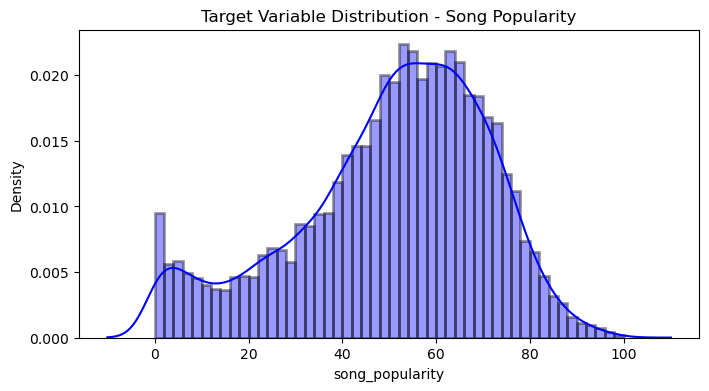

In [23]:
plt.figure(figsize=[8,4])
sns.distplot(df_no_outliers['song_popularity'], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)
plt.title('Target Variable Distribution - Song Popularity')
plt.show()

/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_57680/2993768860.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['song_popularity'], color='black',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)


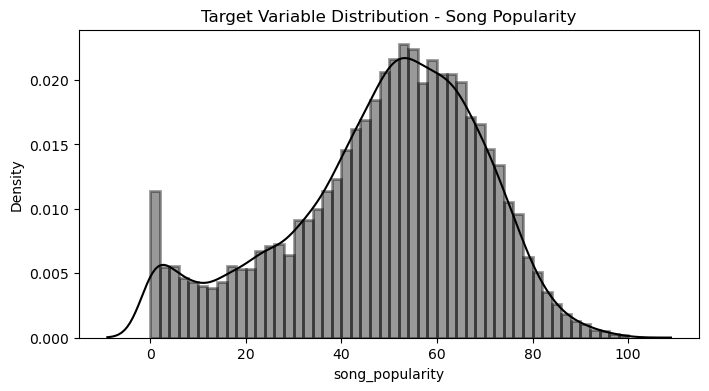

In [26]:
plt.figure(figsize=[8,4])
sns.distplot(df['song_popularity'], color='black',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)
plt.title('Target Variable Distribution - Song Popularity')
plt.show()

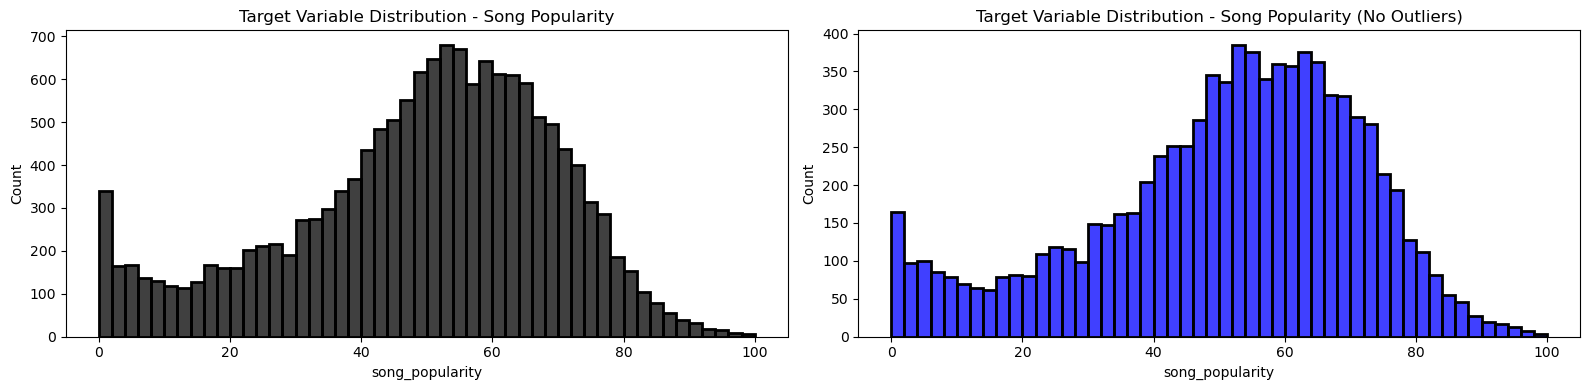

In [27]:
# Configurar a figura com duas subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Plotar o primeiro gráfico
sns.histplot(df['song_popularity'], color='black', edgecolor="black", linewidth=2, bins=50, ax=axes[0])
axes[0].set_title('Target Variable Distribution - Song Popularity')

# Plotar o segundo gráfico
sns.histplot(df_no_outliers['song_popularity'], color='b', edgecolor="black", linewidth=2, bins=50, ax=axes[1])
axes[1].set_title('Target Variable Distribution - Song Popularity (No Outliers)')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

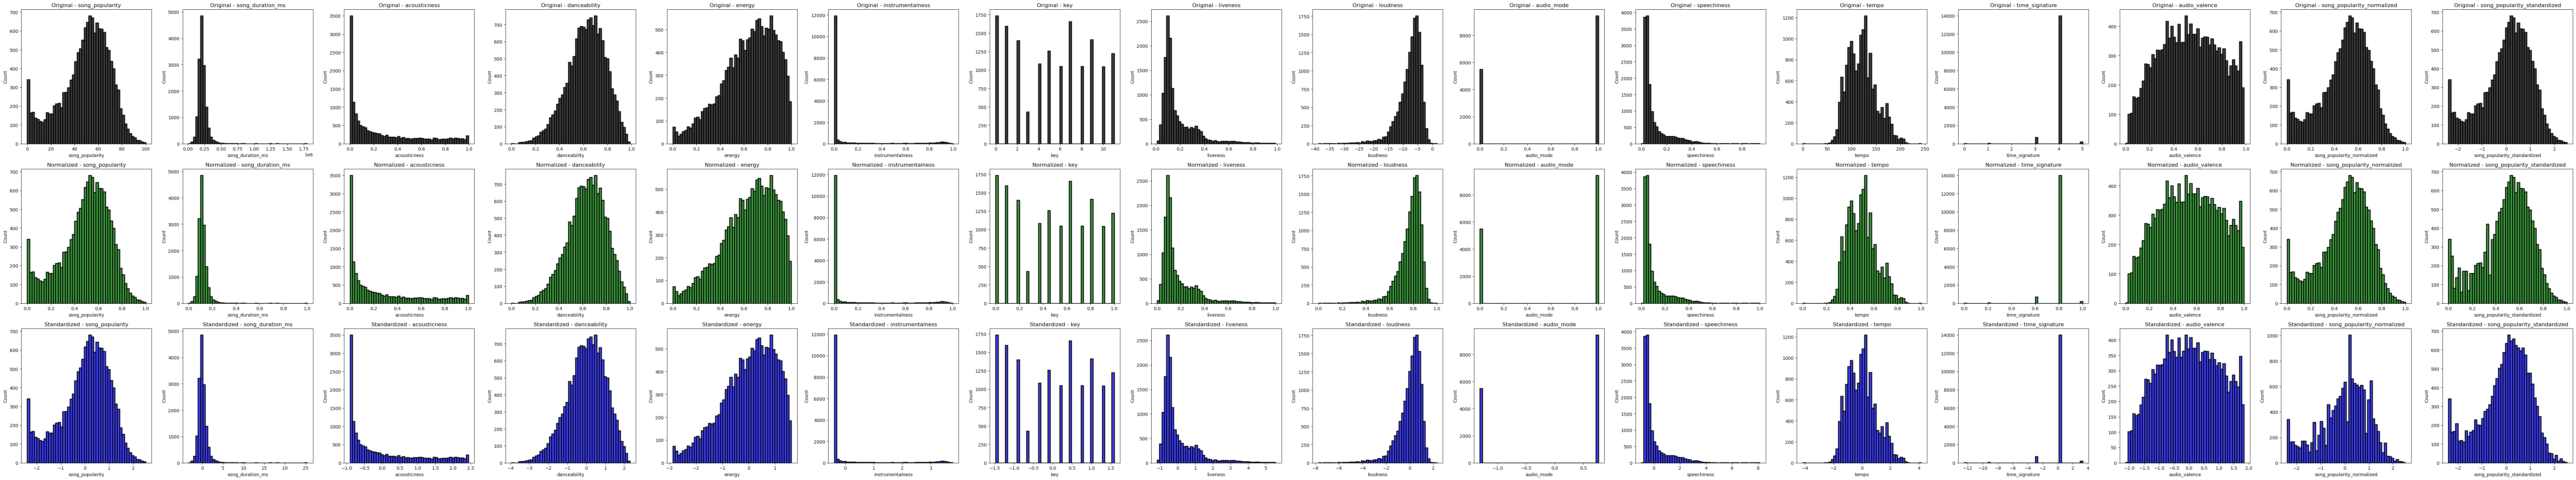

In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Suponha que df é o seu DataFrame original
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Inicializar os normalizadores
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Aplicar a normalização
df_normalized_numeric = pd.DataFrame(min_max_scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Redefinir o índice para garantir que seja único
df_normalized_numeric.index = df.index

# Adicionar colunas que não são numéricas de volta ao DataFrame normalizado
df_normalized = pd.concat([df_normalized_numeric, df.drop(columns=numeric_cols)], axis=1)

# Aplicar a padronização
df_standardized_numeric = pd.DataFrame(standard_scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Redefinir o índice para garantir que seja único
df_standardized_numeric.index = df.index

# Adicionar colunas que não são numéricas de volta ao DataFrame padronizado
df_standardized = pd.concat([df_standardized_numeric, df.drop(columns=numeric_cols)], axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Número de colunas numéricas
num_cols = len(numeric_cols)

# Configurar a figura com subplots para cada coluna numérica
fig, axes = plt.subplots(nrows=3, ncols=num_cols, figsize=(5 * num_cols, 15))

# Garantir que seja uma matriz de eixos
axes = axes.reshape(3, num_cols)

for i, col in enumerate(numeric_cols):
    # Gráfico original
    sns.histplot(df[col], color='black', edgecolor="black", linewidth=2, bins=50, ax=axes[0, i])
    axes[0, i].set_title(f'Original - {col}')
    
    # Gráfico normalizado
    sns.histplot(df_normalized[col], color='green', edgecolor="black", linewidth=2, bins=50, ax=axes[1, i])
    axes[1, i].set_title(f'Normalized - {col}')
    
    # Gráfico padronizado
    sns.histplot(df_standardized[col], color='blue', edgecolor="black", linewidth=2, bins=50, ax=axes[2, i])
    axes[2, i].set_title(f'Standardized - {col}')

# Ajustar layout
plt.tight_layout()
plt.show()



## 4. <a id='toc4_'></a>[Implementação de algoritmos de Aprendizagem Computacional](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Random Forest](#toc0_)

## 5. <a id='toc5_'></a>[Resultados](#toc0_)

## 6. <a id='toc6_'></a>[Considerações finais](#toc0_)